#Pre-reqs

In [ ]:
!git clone https://github.com/sunnytqin/no-distillation.git

Cloning into 'no-distillation'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 112 (delta 38), reused 75 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 13.22 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
!pwd

/content


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
%cd no-distillation/train_expert/

[Errno 2] No such file or directory: 'no-distillation/train_expert/'
/content/no-distillation/softlabel


In [ ]:
!pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [ ]:
!pip3 install torch --index-url https://download.pytorch.org/whl/cu118
!pip3 install torchvision --index-url https://download.pytorch.org/whl/cu118
!pip3 install kornia einops numpy tqdm wandb scipy

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/9

In [ ]:
!pip3 install kornia einops numpy tqdm wandb scipy

^C


# Cifar100

In [ ]:
from torchvision.datasets.cifar import CIFAR100
CIFAR100(root="/content/cifar100/", train=True, download=True)

100%|████████████████████████████████████████████████████████████████████████████████| 169M/169M [03:24<00:00, 828kB/s]


Extracting /content/cifar100/cifar-100-python.tar.gz to /content/cifar100/


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /content/cifar100/
    Split: Train

In [ ]:
# import hard labels from CIFAR100, add random noise to them, and save the new soft labels

import torch
import torchvision
from torchvision import transforms

# --- Config ---
dataset_path = "/content/cifar100/"
output_path = "/content/soft_labels.pt"
num_classes = 100
noise_std = 0.1  # adjust as needed

# --- Load dataset ---
transform = transforms.ToTensor()
dataset = CIFAR100(root=dataset_path, train=True, download=False, transform=transforms.ToTensor())
hard_labels = torch.tensor(dataset.targets)  # shape: [num_samples]

# --- Convert to one-hot ---
soft_labels = torch.nn.functional.one_hot(hard_labels, num_classes=num_classes).float()

# --- Add Gaussian noise ---
noise = torch.normal(mean=0.0, std=noise_std, size=soft_labels.shape)
noisy_soft_labels = soft_labels + noise

# --- Clamp and renormalize to keep valid probability distributions ---
noisy_soft_labels = torch.clamp(noisy_soft_labels, min=1e-6)  # prevent zeros/negatives
noisy_soft_labels /= noisy_soft_labels.sum(dim=1, keepdim=True)  # normalize

# --- Save as expected by your training script ---
torch.save({'soft_labels': noisy_soft_labels}, output_path)

print(f"Saved soft labels to: {output_path}")


Saved soft labels to: /content/soft_labels.pt


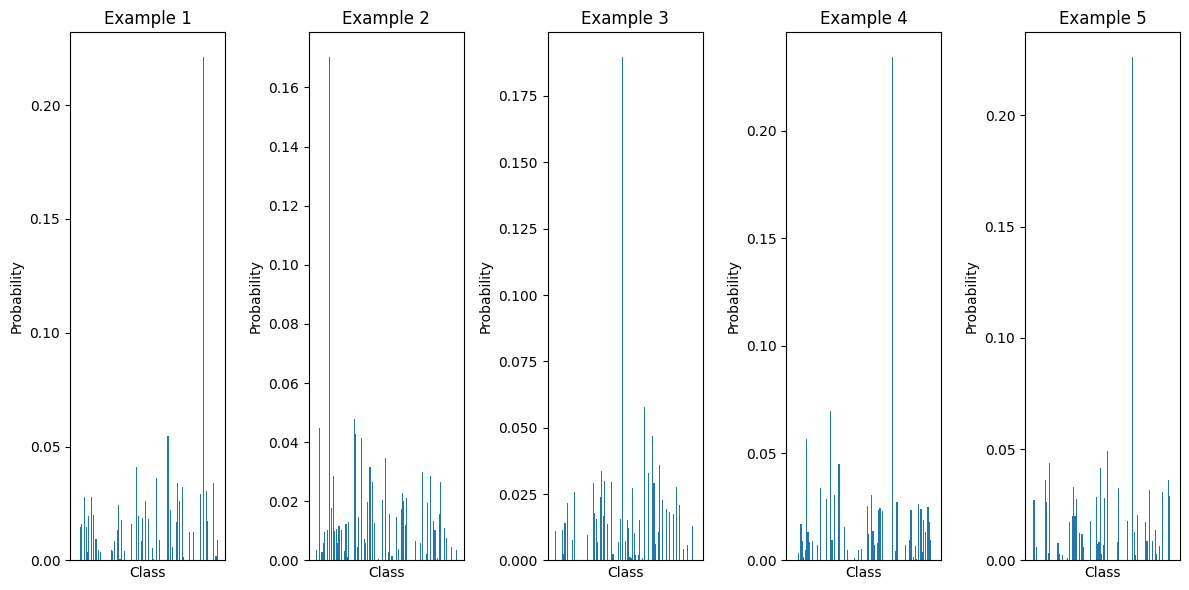

In [ ]:
# Visualize the soft labels

import matplotlib.pyplot as plt
import random

num_examples_to_visualize = 5  # Number of examples to visualize

# Generate random indices for examples
random_indices = random.sample(range(len(noisy_soft_labels)), num_examples_to_visualize)

plt.figure(figsize=(12, 6))  # Adjust figure size if needed

for i, index in enumerate(random_indices):
    plt.subplot(1, num_examples_to_visualize, i + 1)  # Create subplots
    plt.bar(range(num_classes), noisy_soft_labels[index].cpu().numpy())  # Plot soft labels
    plt.title(f"Example {i + 1}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks([])  # Remove x-axis ticks for clarity

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
cd /content/no-distillation/train_expert

/content/no-distillation/train_expert


In [ ]:
import os
print(os.getcwd())


C:\Users\nv1n24\OneDrive - University of Southampton\PhD\Taught Modules\COMP6258\GroupWork\no-distillation


In [ ]:
os.chdir(r"C:\Users\nv1n24\OneDrive - University of Southampton\PhD\Taught Modules\COMP6258\GroupWork\no-distillation\train_expert")

In [ ]:
import os
print(os.getcwd())


C:\Users\nv1n24\OneDrive - University of Southampton\PhD\Taught Modules\COMP6258\GroupWork\no-distillation\train_expert


In [ ]:
# %cd no-distillation/train_expert
!python buffer.py --dataset=CIFAR100 --model=ConvNet --train_epochs=30 --num_experts=1  \
  --buffer_path=.  --data_path=/content/cifar100 --save_interval 1

Files already downloaded and verified
Files already downloaded and verified
Hyper-parameters: 
 {'dataset': 'CIFAR100', 'subset': 'imagenette', 'model': 'ConvNet', 'num_experts': 1, 'lr_teacher': 0.01, 'teacher_label': False, 'selection_strategy': 'random', 'batch_train': 256, 'batch_real': 256, 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'data_path': '/content/cifar100', 'buffer_path': '.', 'train_epochs': 30, 'zca': False, 'decay': False, 'mom': 0, 'l2': 0, 'save_interval': 1, 'device': device(type='cuda'), 'dsa_param': <softlabel.utils.ParamDiffAug object at 0x00000170F1358290>, 'decoder': None}
BUILDING DATASET
BUILDING DATASET
class c = 0: 500 real images
class c = 1: 500 real images
class c = 2: 500 real images
class c = 3: 500 real images
class c = 4: 500 real images
class c = 5: 500 real images
class c = 6: 500 real images
class c = 7: 500 real images
class c = 8: 500 real images
class c = 9: 500 real images
class c = 10: 500 real images
class c = 11: 50


100%|##########| 50000/50000 [00:32<00:00, 1521.89it/s]

0it [00:00, ?it/s]
50000it [00:00, 1671650.17it/s]
C:\Users\nv1n24\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
cd /content/no-distillation/softlabel

/content/no-distillation/softlabel


In [ ]:
!pwd

/content/no-distillation/softlabel


In [ ]:
os.chdir(r"C:\Users\nv1n24\OneDrive - University of Southampton\PhD\Taught Modules\COMP6258\GroupWork\no-distillation\softlabel")

In [ ]:
import os
print(os.getcwd())

C:\Users\nv1n24\OneDrive - University of Southampton\PhD\Taught Modules\COMP6258\GroupWork\no-distillation\softlabel


In [ ]:
# Train Student

!python nodistill.py --dataset=CIFAR100 --ipc=50 --expt_type=add_noise  --teacher_label  \
--max_expert_epoch=30 --lr_net=1.e-02  \
--expert_path=../train_expert \
--data_path=/content/cifar100 --student_model=ConvNet \
--teacher_model=ConvNet --epoch_eval_train=3 --num_eval=1



CUDNN STATUS: True
Files already downloaded and verified
Files already downloaded and verified
Hyper-parameters: 
 {'dataset': 'CIFAR100', 'data_path': '/content/cifar100', 'expert_path': '../train_expert', 'ipc': 50, 'teacher_model': 'ConvNet', 'student_model': 'ConvNet', 'epoch_eval_train': 3, 'optimizer': 'SGD', 'lr_net': 0.01, 'expt_type': 'add_noise', 'num_eval': 1, 'batch_train': 256, 'batch_real': 256, 'zca': False, 'load_checkpoint': None, 'selection_strategy': 'random', 'dsa': True, 'dsa_strategy': 'color_crop_cutout_flip_scale_rotate', 'teacher_label': True, 'max_expert_epoch': 30, 'min_expert_epoch': 1, 'ensemble': False, 'temp': 1.0, 'wandb': False, 'run_name': None, 'notes': 'No description', 'device': 'cuda', 'im_size': [32, 32], 'dc_aug_param': None, 'dsa_param': <utils.ParamDiffAug object at 0x000002AA79A99E10>, '_wandb': {}, 'zca_trans': None, 'distributed': False}
Evaluation model:  ConvNet
---------------Build label to index map--------------
initialize synthetic dat


0it [00:00, ?it/s]
192it [00:00, 1865.72it/s]
397it [00:00, 1972.25it/s]
595it [00:00, 1925.13it/s]
788it [00:00, 1894.69it/s]
992it [00:00, 1900.68it/s]
1189it [00:00, 1910.38it/s]
1391it [00:00, 1925.50it/s]
1584it [00:00, 1919.73it/s]
1776it [00:00, 1911.59it/s]
1972it [00:01, 1923.45it/s]
2165it [00:01, 1897.27it/s]
2377it [00:01, 1937.51it/s]
2571it [00:01, 1929.49it/s]
2772it [00:01, 1952.90it/s]
2984it [00:01, 1953.90it/s]
3198it [00:01, 1961.87it/s]
3399it [00:01, 1964.90it/s]
3601it [00:01, 1977.32it/s]
3804it [00:01, 1990.23it/s]
4010it [00:02, 1994.67it/s]
4211it [00:02, 1982.10it/s]
4421it [00:02, 1989.94it/s]
4626it [00:02, 2004.16it/s]
4829it [00:02, 2008.41it/s]
5034it [00:02, 2019.51it/s]
5236it [00:02, 1997.84it/s]
5436it [00:02, 1988.75it/s]
5710it [00:02, 2185.34it/s]
6030it [00:02, 2479.10it/s]
6340it [00:03, 2660.36it/s]
6607it [00:03, 2472.93it/s]
6858it [00:03, 2264.54it/s]
7090it [00:03, 2196.10it/s]
7313it [00:03, 2144.19it/s]
7530it [00:03, 2115.08it/s]
7743i

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_26800\3783141935.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load("../noisy_labels_std0.05.pt")  # Adjust

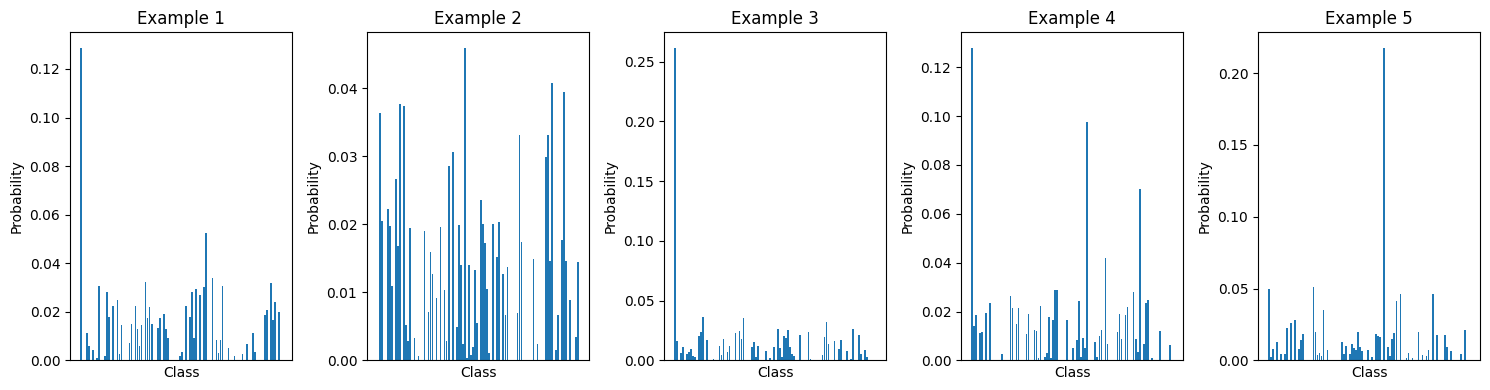

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Load soft labels from file
labels = torch.load("../noisy_labels_std0.05.pt")  # Adjust path if needed

num_classes = labels.shape[1]
num_examples_to_visualize = 5

# Pick random samples
#example_indices = random.sample(range(len(labels)), num_examples_to_visualize)


# Pick non random sample
example_indices = list(range(num_examples_to_visualize))


plt.figure(figsize=(15, 4))

for i, idx in enumerate(example_indices):
    plt.subplot(1, num_examples_to_visualize, i + 1)
    plt.bar(range(num_classes), labels[idx].cpu().numpy())
    plt.title(f"Example {i + 1}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks([])  # Hide class labels for cleaner look

plt.tight_layout()
plt.show()


C:\Users\nv1n24\AppData\Local\Temp\ipykernel_26800\2471582710.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load("../original_soft_labels.pt")  # Adjust

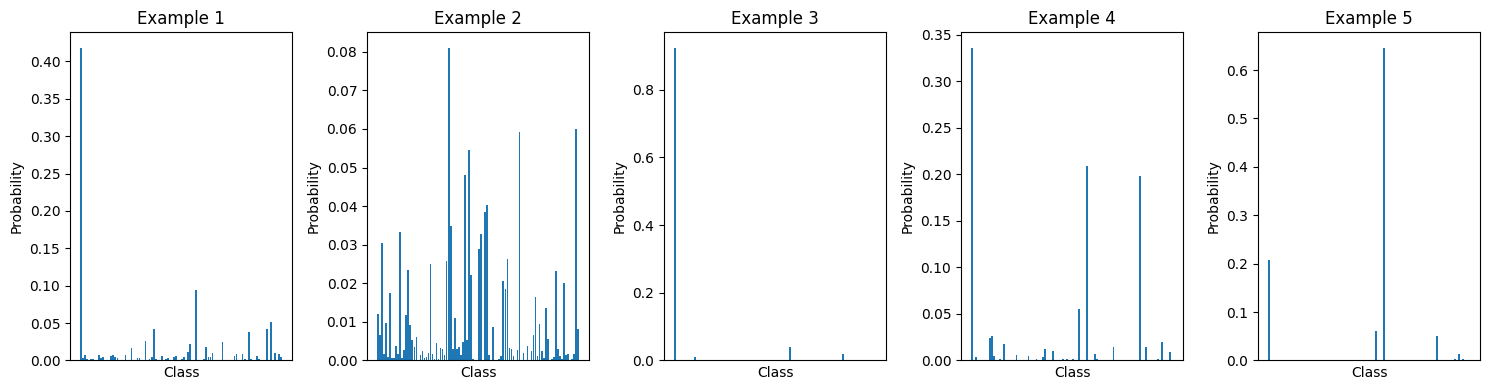

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Load soft labels from file
labels = torch.load("../original_soft_labels.pt")  # Adjust path if needed

num_classes = labels.shape[1]
num_examples_to_visualize = 5

# Pick random samples
#example_indices = random.sample(range(len(labels)), num_examples_to_visualize)


# Pick non random sample
example_indices = list(range(num_examples_to_visualize))


plt.figure(figsize=(15, 4))

for i, idx in enumerate(example_indices):
    plt.subplot(1, num_examples_to_visualize, i + 1)
    plt.bar(range(num_classes), labels[idx].cpu().numpy())
    plt.title(f"Example {i + 1}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.xticks([])  # Hide class labels for cleaner look

plt.tight_layout()
plt.show()
